# WaveHeight Prediction Colab Deployment

Automatically generated by Colaboratory.

Original file is located at: https://colab.research.google.com/drive/your-drive-id

In [2]:
# 1. 克隆仓库
!git clone https://github.com/monthwolf/WaveHeight-Prediction
%cd WaveHeight-Prediction

Cloning into 'WaveHeight-Prediction'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 47 (delta 16), reused 31 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 480.45 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/WaveHeight-Prediction/WaveHeight-Prediction


In [ ]:
# 2. 安装依赖（假设存在requirements.txt）
# 若项目使用特殊库（如PyTorch Lightning），需补充安装命令
!pip install torch scikit-learn numpy netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.0 MB/s eta 0:00:00


# elm.py

In [ ]:
# elm.py
import torch
from torch.autograd import Variable
#from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from swhplot import caloss
from data_cache import *

torch.manual_seed(1) # 设定随机数种子
#mm = MinMaxScaler()
#y_train = torch.tensor(mm.fit_transform(labeltrain)).float()    #归一化处理
# 神经网络结构
net = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 1)
    #torch.nn.ReLU()
    )

def save():
  ihlayer = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.Sigmoid()
  )
  hiddenout = ihlayer(xtrain).squeeze(-1)
  H = np.linalg.pinv(hiddenout.data.numpy().reshape(len(labeltrain),5))    #求广义逆
  T = labeltrain.data.numpy().reshape(len(labeltrain))    #矩阵转置
  beta = np.dot(H,T)    #矩阵相乘
  beta = torch.tensor(beta).float()

  net.state_dict()['0.weight'].copy_(ihlayer.state_dict()['0.weight'])
  net.state_dict()['0.bias'].copy_(ihlayer.state_dict()['0.bias'])
  net.state_dict()['2.weight'].copy_(beta)
  net.state_dict()['2.bias'].copy_(torch.tensor(0))
  # 保存神经网络
  torch.save(net.state_dict(), 'elmnet_params.pkl') # 只保存神经网络的模型参数

# 只载入神经网络的模型参数，神经网络的结构需要与保存的神经网络相同的结构
def reload_params():
  net.load_state_dict(torch.load('elmnet_params.pkl'))
  loss_function = torch.nn.MSELoss()
  prediction = net(xtest).squeeze(-1)
  #prediction = mm.inverse_transform(prediction.data.numpy())
  #prediction = torch.tensor(prediction)
  caloss(prediction,labeltest)
  #测试集图像
  plt.title('test_net')
  param = np.polyfit(labeltest.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)
  p = np.poly1d(param,variable='x')
  rsquare = 1 - loss_function(labeltest,prediction).data.numpy()/np.var(labeltest.data.numpy())    #计算R方
  plt.scatter(labeltest.data.numpy(), prediction.data.numpy())
  plt.xlabel('ytest_label')
  plt.ylabel('ytest_prediction')
  plt.plot(labeltest.data.numpy(), p(labeltest.data.numpy()),'r--')
  plt.text(max(labeltest.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
  plt.show()

  prediction = net(xtrain).squeeze(-1)
  #prediction = mm.inverse_transform(prediction.data.numpy())
  #prediction = torch.tensor(prediction)
  caloss(prediction,labeltrain)
  #训练集图像
  plt.title('train_net')
  param = np.polyfit(labeltrain.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)
  p = np.poly1d(param,variable='x')
  rsquare = 1 - loss_function(labeltrain,prediction).data.numpy()/np.var(labeltrain.data.numpy())    #计算R方
  plt.scatter(labeltrain.data.numpy(), prediction.data.numpy())
  plt.xlabel('ytrain_label')
  plt.ylabel('ytrain_prediction')
  plt.plot(labeltrain.data.numpy(), p(labeltrain.data.numpy()),'r--')
  plt.text(max(labeltrain.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
  plt.show()

{'longitude': "<class 'netCDF4.Dimension'>": name = 'longitude', size = 2, 'latitude': "<class 'netCDF4.Dimension'>": name = 'latitude', size = 3, 'time': "<class 'netCDF4.Dimension'>" (unlimited): name = 'time', size = 1464}
dict_keys(['longitude', 'latitude', 'time', 'msl', 'u10', 'v10', 'swh', 'mwd', 'mwp'])


In [ ]:
save() # 没模型先跑一次

tensor(0.2560)
tensor(0.3193)
46.19838
tensor(0.7087)


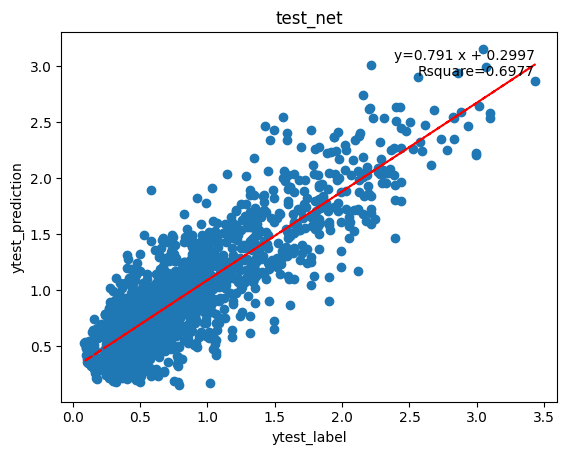

tensor(0.1818)
tensor(0.2586)
41.03521
tensor(0.6904)


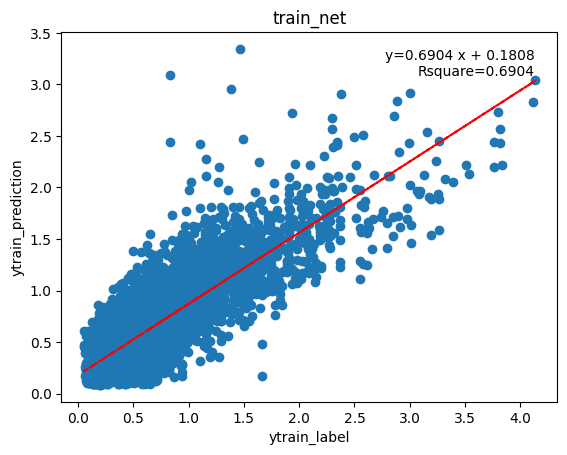

In [ ]:
reload_params() # 重载跑这个

# ipso-elm.py

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 1)
    #torch.nn.Softplus()
    )
ihlayer = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.Sigmoid()
    )
#粒子群算法搜索过程
swarmsize = 100
partlen = 15    #神经网络参数个数
wmax,wmin = 0.9,0.4
c1i = c2f = 2.5
c1f = c2i = 0.5
Iter = 200

def getwgh(fitness,i):
    sum = 0
    for j in fitness:
        sum += j
    if fitness[i] <= sum/swarmsize:
        w = wmin + (wmax - wmin*(fitness[i] - fitness.min()))/(sum/swarmsize - fitness.min())
    else:
        w = wmax
    return w

def getc1c2(iter):
    c1 = (c1i - c1f)*(Iter - iter)/Iter + c1f
    c2 = (c2i - c2f)*(Iter - iter)/Iter + c2f
    return c1,c2

def getrange():
    randompv = (np.random.rand()-0.5)*4
    return randompv

def initswarm():
    vswarm,pswarm = np.zeros((swarmsize,partlen)),np.zeros((swarmsize,partlen))
    for i in range(swarmsize):
        for j in range(partlen):
            vswarm[i][j] = getrange()
            pswarm[i][j] = getrange()
    return vswarm,pswarm

def getfitness(pswarm):
    fitness = np.zeros(swarmsize)
    loss_function = torch.nn.MSELoss()
    for i in range(swarmsize):
        params = pswarm[i]
        ihlayer.state_dict()['0.weight'].copy_(torch.tensor(np.array(params[0:10:1]).reshape(5,2)))
        ihlayer.state_dict()['0.bias'].copy_(torch.tensor(params[10:15:1]))
        hiddenout = ihlayer(xtrain).squeeze(-1)    #计算隐含层输出
        H = np.linalg.pinv(hiddenout.data.numpy().reshape(len(labeltrain),5))    #求广义逆
        T = labeltrain.data.numpy().reshape(len(labeltrain))    #矩阵转置
        beta = np.dot(H,T)    #矩阵相乘
        beta = torch.tensor(beta).float()
        #对net进行初始化
        net.state_dict()['0.weight'].copy_(ihlayer.state_dict()['0.weight'])
        net.state_dict()['0.bias'].copy_(ihlayer.state_dict()['0.bias'])
        net.state_dict()['2.weight'].copy_(beta)
        net.state_dict()['2.bias'].copy_(torch.tensor(0))
        prediction = net(xtrain)
        prediction = prediction.squeeze(-1)
        fitness[i] = loss_function(prediction, labeltrain)
    return fitness

def getpgfit(fitness,pswarm):
    pgfitness = fitness.min()
    pg = pswarm[fitness.argmin()].copy()
    return pg,pgfitness

def optimi():
    vswarm,pswarm = initswarm()
    fitness = getfitness(pswarm)
    pg,pgfit = getpgfit(fitness,pswarm)
    pi,pifit = pswarm.copy(),fitness.copy()
    pgfitlist = []      #存放迭代过程中的全局最优粒子适应值
    for iter in range(Iter):
        if pgfit <= 0.01:
            break
        #更新速度和位置
        for i in range(swarmsize):
            weight = getwgh(fitness,i)
            c1,c2 = getc1c2(iter)
            for j in range(partlen):
                vswarm[i][j] = weight*vswarm[i][j] + c1*np.random.rand()*(pi[i][j]-pswarm[i][j]) + c2*np.random.rand()*(pg[j]-pswarm[i][j])
                pswarm[i][j] = pswarm[i][j] + vswarm[i][j]
        #更新适应值
        fitness = getfitness(pswarm)
        #更新全局最优粒子
        pg,pgfit = getpgfit(fitness,pswarm)
        pgfitlist.append(pgfit)
        #更新局部最优粒子
        for i in range(swarmsize):
            if fitness[i] < pifit[i]:
                pifit[i] = fitness[i].copy()
                pi[i] = pswarm[i].copy()
    #绘制粒子搜索过程全局最优的适应值变化
    plt.title('swarm_fit')
    plt.plot(pgfitlist)
    plt.ylabel('pg_fitness')
    plt.xlabel('iter_num')
    plt.show()
    #最后对全局最优粒子适应值和局部最优进行比较
    for j in range(swarmsize):
        if pifit[j] < pgfit:
            pgfit = pifit[j].copy()
            pg = pi[j].copy()
    #优化完成,初始化参数
    ihlayer.state_dict()['0.weight'].copy_(torch.tensor(np.array(pg[0:10:1]).reshape(5,2)))
    ihlayer.state_dict()['0.bias'].copy_(torch.tensor(pg[10:15:1]))
    hiddenout = ihlayer(xtrain).squeeze(-1)    #计算隐含层输出
    H = np.linalg.pinv(hiddenout.data.numpy().reshape(len(labeltrain),5))    #求广义逆
    T = labeltrain.data.numpy().reshape(len(labeltrain))    #矩阵转置
    beta = np.dot(H,T)    #矩阵相乘
    beta = torch.tensor(beta).float()
    #对net进行初始化
    net.state_dict()['0.weight'].copy_(ihlayer.state_dict()['0.weight'])
    net.state_dict()['0.bias'].copy_(ihlayer.state_dict()['0.bias'])
    net.state_dict()['2.weight'].copy_(beta)
    net.state_dict()['2.bias'].copy_(torch.tensor(0))
    torch.save(net.state_dict(), 'ipsoELM_params.pkl')

def reload_params():
    net.load_state_dict(torch.load('ipsoELM_params.pkl'))
    loss_function = torch.nn.MSELoss()
    prediction = net(xtest)
    prediction = prediction.squeeze(-1)
    caloss(prediction,labeltest)
     #测试集图像
    plt.title('test_net')
    param = np.polyfit(labeltest.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)
    p = np.poly1d(param,variable='x')
    rsquare = 1 - loss_function(labeltest,prediction).data.numpy()/np.var(labeltest.data.numpy())    #计算R方
    plt.scatter(labeltest.data.numpy(), prediction.data.numpy())
    plt.xlabel('ytest_label')
    plt.ylabel('ytest_prediction')
    plt.plot(labeltest.data.numpy(), p(labeltest.data.numpy()),'r--')
    plt.text(max(labeltest.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
    plt.show()

    prediction = net(xtrain)
    prediction = prediction.squeeze(-1)
    caloss(prediction,labeltrain)
    #训练集图像
    plt.title('train_net')
    param = np.polyfit(labeltrain.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)
    p = np.poly1d(param,variable='x')
    rsquare = 1 - loss_function(labeltrain,prediction).data.numpy()/np.var(labeltrain.data.numpy())    #计算R方
    plt.scatter(labeltrain.data.numpy(), prediction.data.numpy())
    plt.xlabel('ytrain_label')
    plt.ylabel('ytrain_prediction')
    plt.plot(labeltrain.data.numpy(), p(labeltrain.data.numpy()),'r--')
    plt.text(max(labeltrain.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
    plt.show()

In [ ]:
# 一样的套路
optimi()

tensor(0.2645)
tensor(0.3526)
40.066505
tensor(0.6484)


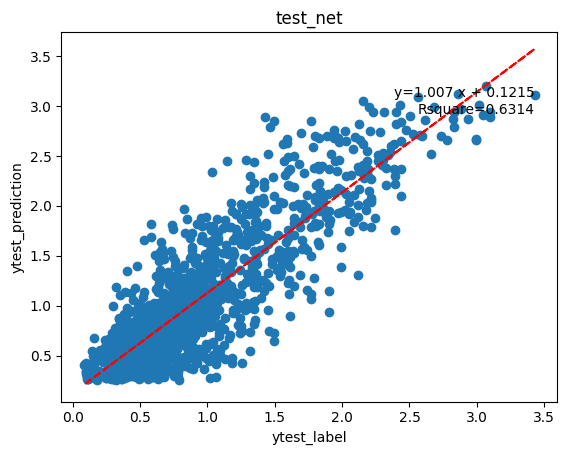

tensor(0.1651)
tensor(0.2340)
38.594116
tensor(0.7465)


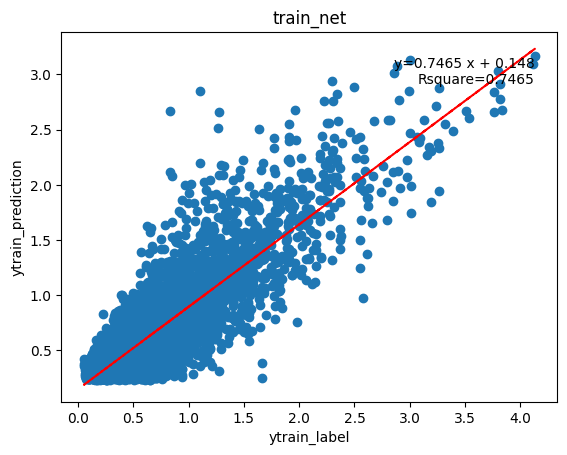

In [ ]:
reload_params()

# bpnn.py

In [ ]:
torch.manual_seed(1) # 设定随机数种子
#mm = MinMaxScaler()
#ytrain = torch.tensor(mm.fit_transform(labeltrain)).float()    #归一化处理
# 将待保存的神经网络定义在一个函数中
def save():
  # 神经网络结构
  net1 = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Softplus()
    )
  optimizer = torch.optim.SGD(net1.parameters(), lr=0.3)
  loss_function = torch.nn.MSELoss()
  loss_array = []
  # 训练部分
  for i in range(500):
    prediction = net1(xtrain)
    prediction = prediction.squeeze(-1)
    loss = loss_function(prediction, labeltrain)
    loss_array.append(loss.data)
    if loss.data <= 0.04:
      break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # 误差曲线
  plt.title('train_loss')
  plt.plot(loss_array)
  plt.ylabel('loss_data')
  plt.xlabel('iter_num')
  plt.show()
  # 保存神经网络
  torch.save(net1.state_dict(), 'net_params.pkl') # 只保存神经网络的模型参数

# 只载入神经网络的模型参数，神经网络的结构需要与保存的神经网络相同的结构
def reload_params():
  # 首先搭建相同的神经网络结构
  net2 = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Softplus()
    )
  # 载入神经网络的模型参数
  net2.load_state_dict(torch.load('net_params.pkl'))
  loss_function = torch.nn.MSELoss()
  prediction = net2(xtest).squeeze(-1)
  #prediction = mm.inverse_transform(prediction.data.numpy())
  #prediction = torch.tensor(prediction)
  caloss(prediction,labeltest)
  #测试集图像
  plt.title('test_net')
  param = np.polyfit(labeltest.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)    #线性回归方程拟合
  p = np.poly1d(param,variable='x')    #输出方程式
  rsquare = 1 - loss_function(labeltest,prediction).data.numpy()/np.var(labeltest.data.numpy())    #计算R方
  plt.scatter(labeltest.data.numpy(), prediction.data.numpy())
  plt.xlabel('ytest_label')
  plt.ylabel('ytest_prediction')
  plt.plot(labeltest.data.numpy(), p(labeltest.data.numpy()),'r--')
  plt.text(max(labeltest.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
  plt.show()

  prediction = net2(xtrain).squeeze(-1)
  #prediction = mm.inverse_transform(prediction.data.numpy())
  #prediction = torch.tensor(prediction)
  caloss(prediction,labeltrain)
  #训练集图像
  plt.title('train_net')
  param = np.polyfit(labeltrain.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)
  p = np.poly1d(param,variable='x')
  rsquare = 1 - loss_function(labeltrain,prediction).data.numpy()/np.var(labeltrain.data.numpy())    #计算R方
  plt.scatter(labeltrain.data.numpy(), prediction.data.numpy())
  plt.xlabel('ytrain_label')
  plt.ylabel('ytrain_prediction')
  plt.plot(labeltrain.data.numpy(), p(labeltrain.data.numpy()),'r--')
  plt.text(max(labeltrain.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
  plt.show()

In [ ]:
save()

tensor(0.2636)
tensor(0.3463)
40.339928
tensor(0.6607)


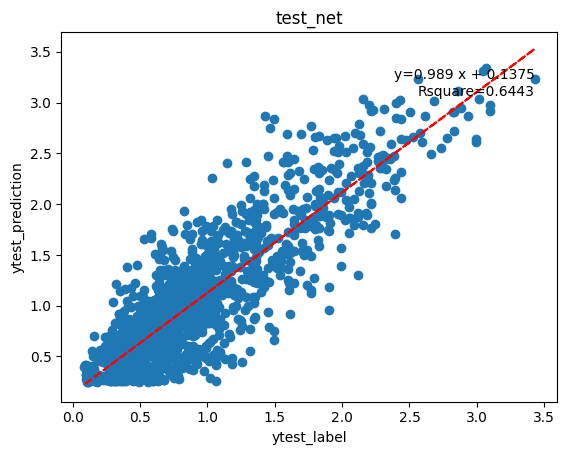

tensor(0.1654)
tensor(0.2355)
38.20153
tensor(0.7432)


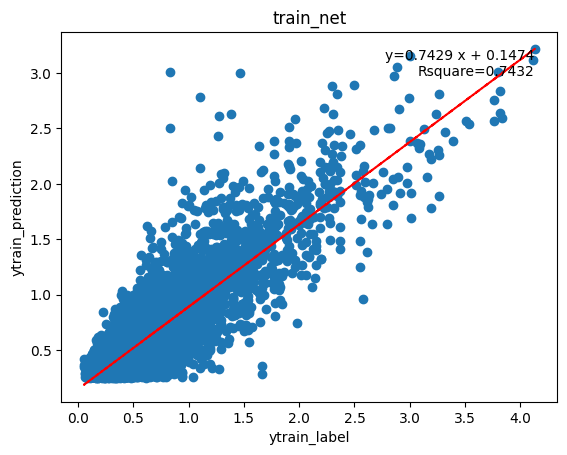

In [ ]:
reload_params()

# ipso-bpnn.py


In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Softplus()
    )
#粒子群算法搜索过程
swarmsize = 100
partlen = 21    #神经网络参数个数
wmax,wmin = 0.9,0.4
c1i = c2f = 2.5
c1f = c2i = 0.5
Iter = 300

def getwgh(fitness,i):
    sum = 0
    for j in fitness:
        sum += j
    if fitness[i] <= sum/swarmsize:
        w = wmin + (wmax - wmin*(fitness[i] - fitness.min()))/(sum/swarmsize - fitness.min())
    else:
        w = wmax
    return w

def getc1c2(iter):
    c1 = (c1i - c1f)*(Iter - iter)/Iter + c1f
    c2 = (c2i - c2f)*(Iter - iter)/Iter + c2f
    return c1,c2

def getrange():
    randompv = (np.random.rand()-0.5)*4
    return randompv

def initswarm():
    vswarm,pswarm = np.zeros((swarmsize,partlen)),np.zeros((swarmsize,partlen))
    for i in range(swarmsize):
        for j in range(partlen):
            vswarm[i][j] = getrange()
            pswarm[i][j] = getrange()
    return vswarm,pswarm

def getfitness(pswarm):
    fitness = np.zeros(swarmsize)
    loss_function = torch.nn.MSELoss()
    for i in range(swarmsize):
        params = pswarm[i]
        net.state_dict()['0.weight'].copy_(torch.tensor(np.array(params[0:10:1]).reshape(5,2)))
        net.state_dict()['0.bias'].copy_(torch.tensor(params[10:15:1]))
        net.state_dict()['2.weight'].copy_(torch.tensor(params[15:20:1]))
        net.state_dict()['2.bias'].copy_(torch.tensor(params[20]))
        prediction = net(xtrain)
        prediction = prediction.squeeze(-1)
        fitness[i] = loss_function(prediction, labeltrain)
    return fitness

def getpgfit(fitness,pswarm):
    pgfitness = fitness.min()
    pg = pswarm[fitness.argmin()].copy()
    return pg,pgfitness

def optimi():
    vswarm,pswarm = initswarm()
    fitness = getfitness(pswarm)
    pg,pgfit = getpgfit(fitness,pswarm)
    pi,pifit = pswarm.copy(),fitness.copy()
    pgfitlist = []      #存放迭代过程中的全局最优粒子适应值
    for iter in range(Iter):
        if pgfit <= 0.01:
            break
        #更新速度和位置
        for i in range(swarmsize):
            weight = getwgh(fitness,i)
            c1,c2 = getc1c2(iter)
            for j in range(partlen):
                vswarm[i][j] = weight*vswarm[i][j] + c1*np.random.rand()*(pi[i][j]-pswarm[i][j]) + c2*np.random.rand()*(pg[j]-pswarm[i][j])
                pswarm[i][j] = pswarm[i][j] + vswarm[i][j]
        #更新适应值
        fitness = getfitness(pswarm)
        #更新全局最优粒子
        pg,pgfit = getpgfit(fitness,pswarm)
        pgfitlist.append(pgfit)
        #更新局部最优粒子
        for i in range(swarmsize):
            if fitness[i] < pifit[i]:
                pifit[i] = fitness[i].copy()
                pi[i] = pswarm[i].copy()
    #绘制粒子搜索过程全局最优的适应值变化
    plt.title('swarm_fit')
    plt.plot(pgfitlist)
    plt.ylabel('pg_fitness')
    plt.xlabel('iter_num')
    plt.show()
    #最后对全局最优粒子适应值和局部最优进行比较
    for j in range(swarmsize):
        if pifit[j] < pgfit:
            pgfit = pifit[j].copy()
            pg = pi[j].copy()
    #优化完成,初始化参数
    net.state_dict()['0.weight'].copy_(torch.tensor(np.array(pg[0:10:1]).reshape(5,2)))
    net.state_dict()['0.bias'].copy_(torch.tensor(pg[10:15:1]))
    net.state_dict()['2.weight'].copy_(torch.tensor(pg[15:20:1]))
    net.state_dict()['2.bias'].copy_(torch.tensor(pg[20]))
    torch.save(net.state_dict(), 'ipsoBP_params.pkl')

# 训练部分
def save_train():
    net.load_state_dict(torch.load('ipsoBP_params.pkl'))
    optimizer = torch.optim.SGD(net.parameters(), lr=0.05)
    loss_function = torch.nn.MSELoss()
    loss_array = []
    for i in range(300):
        prediction = net(xtrain)
        prediction = prediction.squeeze(-1)
        loss = loss_function(prediction, labeltrain)
        loss_array.append(loss.data)
        if loss.data <= 0.01:
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #训练集图像
    caloss(prediction,labeltrain)
    plt.title('train_net')
    param = np.polyfit(labeltrain.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)
    p = np.poly1d(param,variable='x')
    rsquare = 1 - loss.data.numpy()/np.var(labeltrain.data.numpy())    #计算R方
    plt.scatter(labeltrain.data.numpy(), prediction.data.numpy())
    plt.xlabel('ytrain_label')
    plt.ylabel('ytrain_prediction')
    plt.plot(labeltrain.data.numpy(), p(labeltrain.data.numpy()),'r--')
    plt.text(max(labeltrain.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
    plt.show()
    # 误差曲线
    plt.title('train_loss')
    plt.plot(loss_array)
    plt.ylabel('loss_data')
    plt.xlabel('iter_num')
    plt.show()
    # 保存神经网络
    torch.save(net.state_dict(), 'ipsoBP_params.pkl') # 只保存神经网络的模型参数

def reload_test():
    # 载入神经网络的模型参数
    net.load_state_dict(torch.load('ipsoBP_params.pkl'))
    loss_function = torch.nn.MSELoss()
    prediction = net(xtest)
    prediction = prediction.squeeze(-1)
    caloss(prediction,labeltest)
    #测试集图像
    plt.title('test_net')
    param = np.polyfit(labeltest.squeeze(-1).data.numpy(), prediction.squeeze(-1).data.numpy(),1)
    p = np.poly1d(param,variable='x')
    rsquare = 1 - loss_function(labeltest,prediction).data.numpy()/np.var(labeltest.data.numpy())    #计算R方
    plt.scatter(labeltest.data.numpy(), prediction.data.numpy())
    plt.xlabel('ytest_label')
    plt.ylabel('ytest_prediction')
    plt.plot(labeltest.data.numpy(), p(labeltest.data.numpy()),'r--')
    plt.text(max(labeltest.data),max(prediction.data),'y='+str(p).strip()+'\nRsquare='+str(round(rsquare,4)),verticalalignment="top",horizontalalignment="right")
    plt.show()



In [ ]:
#运行测试
optimi()
save_train()

tensor(0.2703)
tensor(0.3626)
40.962963
tensor(0.6303)


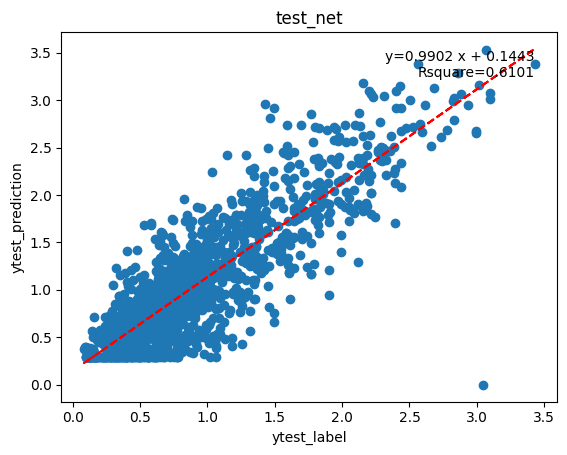

In [ ]:
reload_test()

# 对比所有模型预测

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from data_cache import *

# 绘制海浪高度时间序列函数
def swhplot():
    """
    绘制海浪高度时间序列图

    该函数绘制训练集和测试集的海浪高度随时间变化的曲线图，
    用于直观展示海浪高度的变化趋势和时间特性
    """
    # 绘制训练集海浪高度时间序列
    plt.title('train_swh')
    plt.plot(swh[0:16104:1])
    plt.xlabel('data_no')  # X轴表示数据点序号
    plt.ylabel('Swh')      # Y轴表示海浪高度(m)
    plt.show()

    # 绘制测试集海浪高度时间序列
    plt.title('test_swh')
    plt.plot(swh[16104:17568:1])
    plt.xlabel('data_no')  # X轴表示数据点序号
    plt.ylabel('Swh')      # Y轴表示海浪高度(m)
    plt.show()

# 计算多种评价指标函数
def caloss(prediction, label):
    """
    计算模型预测结果的多种评价指标

    参数:
        prediction: 模型预测值
        label: 真实标签值

    输出:
        打印MAE(平均绝对误差)、RMSE(均方根误差)、MAPE(平均绝对百分比误差)、NSE(Nash-Sutcliffe效率系数)
    """
    # 计算MAE(平均绝对误差)：衡量预测值与真实值的平均绝对差异
    mae = torch.nn.L1Loss()(prediction, label).data

    # 计算MSE(均方误差)：衡量预测值与真实值差异的平方和的平均值
    mse = torch.nn.MSELoss()(prediction, label).data

    # 计算RMSE(均方根误差)：MSE的平方根，能够反映预测值与真实值的平均偏差
    rmse = np.sqrt(mse)

    # 计算MAPE(平均绝对百分比误差)：衡量预测值相对于真实值的平均绝对百分比误差
    mape = np.mean(np.abs((prediction.data.numpy() - label.data.numpy()) / label.data.numpy())) * 100

    # 计算NSE(Nash-Sutcliffe效率系数)：评价模型预测效果相对于简单平均值模型的改进程度
    # NSE = 1表示完美预测，NSE = 0表示预测效果与使用观测均值一样好，NSE < 0表示均值模型更好
    premean = prediction*0 + torch.tensor(np.mean(prediction.data.numpy()))
    nse = 1 - (mse/torch.nn.MSELoss()(premean, label).data)

    # 打印各项评价指标
    print(mae)    # 输出MAE
    print(rmse)   # 输出RMSE
    print(mape)   # 输出MAPE
    print(nse)    # 输出NSE

In [23]:
# @title Pip install graphcast and dependencies
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX



PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2025-03-29 13:55:06--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.176.84, 104.18.177.84, 2606:4700::6812:b054, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.176.84|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2025-03-29 13:55:06--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh.1’

     0K .......... .......... .......... .......... ..........  0% 8.24M 7s
    50K .......... .......... .......... .......... ........

In [27]:
!conda create -n ai-models python=3.10
!source activate ai-models
!conda install cudatoolkit
!pip install ai-models
!pip install --upgrade pip
!pip install ai-models-panguweather ai-models-fourcastnet ai-models-graphcast


CondaValueError: prefix already exists: /usr/local/envs/ai-models

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.4
  latest version: 25.3.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

  Using cached https://files.pythonhosted.org/packages/d3/92/d73a848ced08afa8ed09272b9b1cc00fb8f8a12274edd2429a1f5603f881/ai-models-0.5.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/35/a8/365059bbcd45

In [20]:
!pip install jaxlib==0.1.69+cuda111

--2025-03-29 14:23:23--  https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.23+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129027530 (123M) [application/octet-stream]
Saving to: ‘jaxlib-0.4.23+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl.1’

jaxlib-0.4.23+cuda1 100%[===================>] 123.05M   200MB/s    in 0.6s    

2025-03-29 14:23:24 (200 MB/s) - ‘jaxlib-0.4.23+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl.1’ saved [129027530/129027530]

ERROR: jaxlib-0.4.23+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl is not a supported wheel on this platform.


In [18]:
!ai-models --input cds --date 20230920 --time 0000 --assets assets-panguweather panguweather

2025-03-29 14:20:29,163 INFO Writing results to panguweather.grib
2025-03-29 14:20:29,163 INFO Loading pressure fields from CDS
2025-03-29 14:20:29,761 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-29 14:20:29,761 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-29 14:20:29,761 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-29 14:20:29,761 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax 

In [22]:
!ai-models --download-assets --assets assets-fourcastnet --input cds --date 20230920 --time 0000 fourcastnet

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-03-29 14:24:26,239 INFO Writing results to fourcastnet.grib
2025-03-29 14:24:26,239 INFO Loading assets-fourcastnet/global_means.npy
2025-03-29 14:24:26,240 INFO Loading assets-fourcastnet/global_stds.npy
2025-03-29 14:24:26,240 INFO Loading surface fields from CDS
2025-03-29 14:24:26,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-29 14:24:26,805 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-29 14:24:26,806 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failin

In [21]:
!ai-models --download-assets --assets assets-graphcast --input cds --date 20230920 --time 0000 graphcast

2025-03-29 14:24:17,002 INFO NumExpr defaulting to 2 threads.
2025-03-29 14:24:17,576 INFO Total time: 1 second.
Traceback (most recent call last):
  File "/usr/local/bin/ai-models", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ai_models/__main__.py", line 362, in main
    _main(sys.argv[1:])
  File "/usr/local/lib/python3.11/dist-packages/ai_models/__main__.py", line 310, in _main
    run(vars(args), unknownargs)
  File "/usr/local/lib/python3.11/dist-packages/ai_models/__main__.py", line 319, in run
    model = load_model(cfg["model"], **cfg, model_args=model_args)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ai_models/model.py", line 611, in load_model
    return available_models()[name].load()(**kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/entrypoints.py", line 79, in load
    mod = import_module(

In [4]:
%pip install --upgrade https://github.com/deepmind/graphcast/archive/master.zip

# Workaround for cartopy crashes due to the shapely installed by default in
# google colab kernel (https://github.com/anitagraser/movingpandas/issues/81):
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

     \ 1.7 MB 16.2 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.9/708.9 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for graphcast: filename=graphcast-0.2.0.dev0-py3-none-any.whl size=132343 sha256=57b4f0636396a98003941064aa344fd863bde759aad510e6ed8ede15fdeef394
  Stored in directory: /tmp/pip-ephem-wheel-ca

In [16]:
!pip uninstall numpy scipy pandas -y

!pip install scipy numpy==1.26.4 pandas==2.2.1
!pip install xarray

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: pandas 2.2.1
Uninstalling pandas-2.2.1:
  Successfully uninstalled pandas-2.2.1
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pandas-2.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
ERROR: pip's dependency resolver does not currently take into account all th

In [ ]:
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

# load data
ds_fourcast = xr.open_dataset('fourcastnet.grib')

ix_step = 3  # 0 = first step in weather prediction
ix_level = 0 # 0 = surface pressure level
temp_degC = ds_fourcast['t'][ix_step, ix_level] - 273.15 # subtract 273.15 to convert from Kelvin to Celsius.

# plot settings
sns.set_style('ticks')
tmin = -45
tmax = +45
nlev = 19


# generate figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines('110m', alpha=0.1)

# contour plot
img = ax.contourf(ds_fourcast.longitude.values, ds_fourcast.latitude.values,
                  temp_degC.values,
                  levels = np.linspace(tmin, tmax, nlev),
                  cmap='RdBu_r',
                  transform=ccrs.PlateCarree()
                 )

# hours passed since initialization
dt_hours = ((ds_fourcast['valid_time'][ix_step] - ds_fourcast['time']).values / 1e9 / 3600).astype(float)

# annotation text
ax.text(-180, 90,
        f'After {dt_hours} hours ({ds_fourcast["valid_time"][ix_step].values})',
        transform=ccrs.PlateCarree(),
        va='bottom', ha='left',
       )

plt.colorbar(img, orientation='horizontal', label='850 hPa temperature (°C)')
plt.show()



ERROR:cfgrib.dataset:skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=2.0)
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


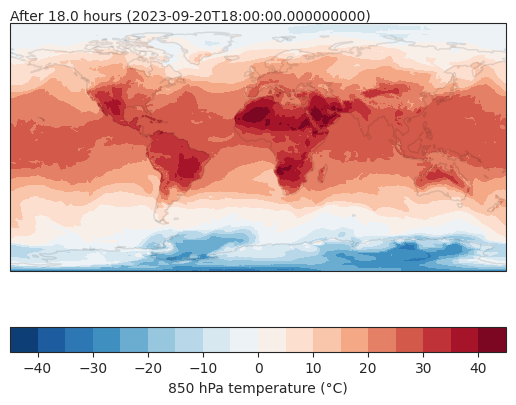

In [24]:
import xarray as xr
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

# load data
ds_fourcast = xr.open_dataset('panguweather.grib')

ix_step = 3  # 0 = first step in weather prediction
ix_level = 0 # 0 = surface pressure level
temp_degC = ds_fourcast['t'][ix_step, ix_level] - 273.15 # subtract 273.15 to convert from Kelvin to Celsius.

# plot settings
sns.set_style('ticks')
tmin = -45
tmax = +45
nlev = 19


# generate figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines('110m', alpha=0.1)

# contour plot
img = ax.contourf(ds_fourcast.longitude.values, ds_fourcast.latitude.values,
                  temp_degC.values,
                  levels = np.linspace(tmin, tmax, nlev),
                  cmap='RdBu_r',
                  transform=ccrs.PlateCarree()
                 )

# hours passed since initialization
dt_hours = ((ds_fourcast['valid_time'][ix_step] - ds_fourcast['time']).values / 1e9 / 3600).astype(float)

# annotation text
ax.text(-180, 90,
        f'After {dt_hours} hours ({ds_fourcast["valid_time"][ix_step].values})',
        transform=ccrs.PlateCarree(),
        va='bottom', ha='left',
       )

plt.colorbar(img, orientation='horizontal', label='850 hPa temperature (°C)')
plt.show()



In [ ]:
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

# load data
ds_pangu = xr.open_dataset('fourcastnet.grib')

ix_step = 3  # 0 = first step in weather prediction
ix_level = 8 # 0 = surface pressure level, 2 - 850 hPa level
windspeed = (ds_pangu['u'][ix_step, ix_level]**2 + ds_pangu['u'][ix_step, ix_level]**2)**0.5

# plot settings
sns.set_style('ticks')
tmin = 0
tmax = 150
nlev = 16

# generate figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_latitude=-30))
ax.set_global()
ax.coastlines('110m', alpha=1.0)

# contour plot
img = ax.contourf(ds_pangu.longitude.values, ds_pangu.latitude.values,
                  windspeed.values,
                  levels = np.linspace(tmin, tmax, nlev),
                  cmap='gist_ncar',
                  transform=ccrs.PlateCarree()
                 )

# hours passed since initialization
dt_hours = ((ds_pangu['valid_time'][ix_step] - ds_pangu['time']).values / 1e9 / 3600).astype(float)
print(dt_hours)

plt.colorbar(img, orientation='horizontal', label='Wind speed (m/s)', shrink=0.5)
plt.show()



ERROR:cfgrib.dataset:skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=2.0)
/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


18.0


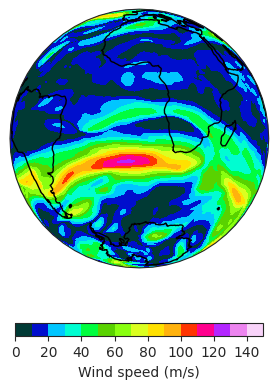

In [25]:
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

# load data
ds_pangu = xr.open_dataset('panguweather.grib')

ix_step = 3  # 0 = first step in weather prediction
ix_level = 8 # 0 = surface pressure level, 2 - 850 hPa level
windspeed = (ds_pangu['u'][ix_step, ix_level]**2 + ds_pangu['u'][ix_step, ix_level]**2)**0.5

# plot settings
sns.set_style('ticks')
tmin = 0
tmax = 150
nlev = 16

# generate figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_latitude=-30))
ax.set_global()
ax.coastlines('110m', alpha=1.0)

# contour plot
img = ax.contourf(ds_pangu.longitude.values, ds_pangu.latitude.values,
                  windspeed.values,
                  levels = np.linspace(tmin, tmax, nlev),
                  cmap='gist_ncar',
                  transform=ccrs.PlateCarree()
                 )

# hours passed since initialization
dt_hours = ((ds_pangu['valid_time'][ix_step] - ds_pangu['time']).values / 1e9 / 3600).astype(float)
print(dt_hours)

plt.colorbar(img, orientation='horizontal', label='Wind speed (m/s)', shrink=0.5)
plt.show()

